This notebook calculates the basic cosmologigal quantities in various dynamical dark energy models:
Equation of State (EoS) $w = p/\rho$ for Dark Energy models is given by:

1. CPL: $w_{CPL} = w_0 + w_a \left( \frac{z}{1+z} \right)$
2. BA: $w_{BA} = w_0 + w_a \left( \frac{z(1 + z)}{1+z^2} \right)$
3. FSL: $w_{FSL} = $

1. <span style="color:blue; font-weight: bold;">Hubble Rate:</span> 
$H(z) = H_0 \sqrt{\Omega_m^{(0)} (1 + z)^3 + (1 - \Omega_m^{(0)}) \exp \left( 3 \int_0^z \frac{1 + w(z')}{1 + z'} dz' \right)}$

where: $H_0$ is the Hubble constant at present, $\Omega_m^{(0)}$ is the present matter density parameter, $w(z)$ is the equation of state of dark energy as a function of redshift $z$.

function: `Hubble_rate` variable: `z`, method=`"CPL"`**
**method set default `CPL` change to `BA`, `FSL` as per the convenience.

2. <span style="color:blue; font-weight: bold;">Comoving distance:</span> 
$\chi (z) = \frac{c}{H_0} \int_0^z \frac{dz'}{E(z)}$
where $E(z) = H(z)/H(z=0)$

function: `Comoving_distance` variable: `z`, method=`"CPL"`

3. <span style="color:blue; font-weight: bold;">Angular diameter distance:</span> 
$D_A (z) = \frac{\chi(z)}{1+z}$

function: `Angular_diameter_distance` variable: `z`, method=`"CPL"`

4. <span style="color:blue; font-weight: bold;">Luminosity distance:</span> 
$D_A (z) = \chi(z)(1+z)$

function: `Luminosity_distance` variable: `z`, method=`"CPL"`

5. <span style="color:blue; font-weight: bold;">Growth of Structure:</span> 
$D_+ (z)$ obtained by solving $ \frac{d^2\delta}{da^2} = -\left( \frac{3}{a} + \frac{dH}{da}\frac{1}{E(z)}\right)  \frac{d\delta}{da} + \frac{3}{2} \frac{\Omega_m}{a^2} \delta$

To solve the equation we $\delta$ grows linearly as a function of $a$ at very very very hight redshift (typically $a\approx 0.001$)

function: `D_plus_z` variable: `z`, method=`"CPL"`

6. <span style="color:blue; font-weight: bold;">Logarithmic Growth rate:</span> 
$f (z) = \frac{d\log D_+}{d \log a}$

function: `growth_rate_z` variable: `z`, method=`"CPL"`

7. <span style="color:blue; font-weight: bold;">$f\sigma_8$</span>
This function returns the growth rate of dark matter fluctuation at a sphere of radius $8$Mpc$^{-1}$ as a function of redshift
$f\sigma_8 = \frac{d\log D+}{d \log a} \times \sigma_8 \frac{ D_+(z)}{D_+(z=0)}$
        
function: `f_sigma8_z` variable: `z`, method=`"CPL"`

8. <span style="color:blue; font-weight: bold;">effective distance (BAO):</span>
It is given by $D_v =  \left( (1+z)^2  \frac{D_A(z)^2 ~ c ~ z}{H(z)}\right)^{1/3}$ unit of length (MPc)

function: `BAO_DV` variable: `z`, method=`"CPL"`

In [3]:
import numpy as np
from scipy.integrate import quad
import functools
from scipy.integrate import odeint
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt


class vectorize(np.vectorize):
    def __get__(self, obj, objtype):
        return functools.partial(self.__call__, obj)



In [4]:

class EquationOfState:
    def __init__(self, w0, wa):
        self.w0 = w0
        self.wa = wa

    def CPL(self, z):
        return (1 + z) ** (3 * (1 + self.w0 + self.wa)) * np.exp(-3 * self.wa * z / (1 + z))

    def JBP(self, z):
        return (1 + z) ** (3 * (1 + self.w0)) * np.exp(3 * self.wa * z**2 / (2 * (1 + z)**2))

    def BA(self, z):
        return (1 + z) ** (3 * (1 + self.w0)) * (1 + z ** 2) ** (3 * self.wa / 2)

    def FSL(self, z):
        FSL1 = (1 + z) ** (3 * (1 + self.w0)) * np.exp(3 * self.wa * np.arctan(z) / 2) * \
               (1 + z ** 2) ** (3 * self.wa / 4) * (1 + z) ** (-3 * self.wa / 2)
        FSL2 = (1 + z) ** (3 * (1 + self.w0)) * np.exp(-3 * self.wa * np.arctan(z) / 2) * \
               (1 + z ** 2) ** (3 * self.wa / 4) * (1 + z) ** (3 * self.wa / 2)
        return FSL1, FSL2


class Background:
    def __init__(self, Om, eos_model):
        self.Om = Om
        self.H0 = 67.66
        self.eos_model = eos_model

    @vectorize
    def Hubble_rate(self, z, method="CPL"):
        if method == "CPL":
            dark_energy = self.eos_model.CPL(z)
        elif method == "JBP":
            dark_energy = self.eos_model.JBP(z)
        elif method == "BA":
            dark_energy = self.eos_model.BA(z)
        elif method == "FSL":
            dark_energy, _ = self.eos_model.FSL(z)
        else:
            raise ValueError("Invalid method. Choose from 'CPL', 'JBP', 'BA', or 'FSL'.")
        return self.H0 * np.sqrt(self.Om * (1 + z) ** 3 + (1 - self.Om) * dark_energy)
    
    @vectorize
    def Comoving_distance(self, z, method="CPL"):
        """
        Compute the comoving distance to a given redshift.

        Parameters:
        z (float): Redshift value.
        method (str): Method to use for Hubble rate calculation. Default is "CPL".

        Returns:
        float: Comoving distance in units of c/H0.
        """
        DH = 2997.98 * 100 / self.H0 
        integral, _ = quad(lambda z_: self.H0 / self.Hubble_rate(z_, method), 0, z)
        return integral * DH

    def Angular_diameter_distance(self, z, method="CPL"):
        """
        Compute the angular diameter distance.
        Parameters:
        z (float): Redshift value.
        method (str): Method to use for Hubble rate calculation. Default is "CPL".
        Returns:
        float: Angular diameter distance in units of c/H0.
        """
        comoving_distance = self.Comoving_distance(z, method)
        return comoving_distance / (1 + z)

    def Luminosity_distance(self, z, method="CPL"):
        """
        Compute the luminosity distance.
        Parameters:
        z (float): Redshift value.
        method (str): Method to use for Hubble rate calculation. Default is "CPL".
        Returns:
        float: Luminosity distance in units of c/H0.
        """
        comoving_distance = self.Comoving_distance(z, method)
        return comoving_distance * (1 + z)

    @vectorize
    def hubble_normalized_z(self, z, method="CPL"):
        '''
        This function returna the normalized Hubble expression
        H(z) = H0*sqrt(Om_m(1+z)^3+Om_DE)
        '''
        return self.Hubble_rate(z, method)/self.H0
    
    def inverse_hubble_normalized_z(self, z, method="CPL"):
        '''
        Inverse of the normalized hubble parameter : 1/h(z)
        where  h(z)= H(z)/H0
        '''
        return 1./self.hubble_normalized_z(z, method)
    
    def hubble_normalized_a(self, a, method="CPL"):
        '''
        Calculates normalized Hubble parameter h(a)= H(a)/H0
        where H(a) is the Hubble parameter at redshift z and 
        H0 is the current value of Hubble parameter
        '''
        return self.hubble_normalized_z(1./a - 1, method)
    
    def hubble_prime_normalized_a(self, a, method="CPL"):
        '''
        Derivative of dimensionless hubble parameter w.r.t a
        '''
        dx = 1e-6
        return (self.hubble_normalized_a(a + dx, method) - self.hubble_normalized_a(a - dx, method)) / (2 * dx)

    def om_0_a(self, a, method="CPL"):
        '''
        Omega matter as a function of scale factor
        '''
        return self.Om*a**(-3)/self.hubble_normalized_a(a, method)**2.0
    
    def om_0_z(self, z, method="CPL"):
        '''
        Omega matter as a function of redshift
        '''        
        return self.om_0_a(1./(1.+z), method)
 
    a_factor = np.linspace(0.01, 1, 10000)
        
    def deriv(self, y, a, method="CPL"):
        #print(f"Method: {method}, a: {a}")

        h_prime = self.hubble_prime_normalized_a(a, method)
        h_norm = self.hubble_normalized_a(a, method)
        omega_m = self.om_0_a(a, method)

        #print(f"H'(a): {h_prime}, H(a): {h_norm}, Omega_m(a): {omega_m}")

        der = [y[1], -(3./a + h_prime / h_norm) * y[1] + 1.5 * omega_m * y[0] / (a**2.)]
        return der
    
    def solution(self, method="CPL"):
        '''
        Soution to the matter perturbation 
        Initial condition chosen at early matter dominated area 
        Dm=a=dD/dm at a=0.001
        '''
        y_initial = (0.01,1)
        return odeint(self.deriv, y_initial, self.a_factor, args=(method,), rtol=1e-8, atol=1e-10)
    
    def D_p(self, a, method="CPL"):
        '''
        This function does not calculate anything but 
        extracts the solution of the differential equation
        Do not call the function, it does give any output
        '''
        y11 = self.solution(method)[:,0]
        ynn11 = UnivariateSpline(self.a_factor, y11, k=3, s=0)
        return ynn11(a)

    def D_plus_a(self, a, method="CPL"):
        '''
        This function return the growing mode solution
        as a function of scale factor i.e D+(a)/D+(a=1) 
        normalized at present epoch
        '''
        return self.D_p(a, method)
    
    @vectorize
    def D_plus_z(self, z, method="CPL"):
        '''
        Normalized solution of the growing mode as a function of redshift z
        '''
        return self.D_plus_a(1./(1.+z), method)

    def growth_rate_a(self, a, method="CPL"):
        '''
        This function returns the growth rate as a function of scale factor
        Mathematically dlog(D)/dlog(a)
        '''
        d = self.solution(method)[: , :]
        d1 = d[:,0]
        d2 = d[:,1]
        grate1 = UnivariateSpline(self.a_factor, self.a_factor*d2/d1, k=3, s=0)
        return grate1(a)
    
    def growth_rate_z(self, z, method="CPL"):
        '''
        This function returns the growth rate as a function of redshift
        Mathematically f = d(log(D+))/d(log(a))
        '''
        return self.growth_rate_a(1./(1.+z), method)

    def f_sigma8_z(self, z, method="CPL"):
        '''
        This function returns the growth rate of DM fluctuation at a sphere of radius 8Mpc-1 as a function of redshift
        Mathematically f\sigma_8 = d(log(D+))/d(log(a)) * \sigma_8 * D+(z)/D+(z=0)
        '''
        sigma8 = 0.8
        return self.growth_rate_z(z, method) * sigma8 * self.D_plus_z(z, method) / self.D_plus_z(0, method)

    def BAO_DV(self, z, method="CPL"):
        '''
        This function returns the effective distance ratio as a function of redshift
        Mathematically Dv = [(1+z)^2 * D_a(z)^2 c * z / H(z)]^{1/3} unit of length (MPc)
        '''
        DA_sq = self.Angular_diameter_distance(z, method)**2
        Hz = self.Hubble_rate(z, method)
        Dv = (1 + z)**2 * DA_sq * c * z / Hz 
        return Dv**(1/3)
    
    

<>:192: SyntaxWarning: invalid escape sequence '\s'
<>:192: SyntaxWarning: invalid escape sequence '\s'
/var/folders/5x/8nb9m24s1tx2mqxjl2lx62b40000gn/T/ipykernel_11236/1580593421.py:192: SyntaxWarning: invalid escape sequence '\s'
  '''


In [7]:
Om = 0.311
ref_eos = EquationOfState(-1.0, 0.0)  # Choose w0 = -1.0, wa = 0
bg_ref = Background(Om, ref_eos) 


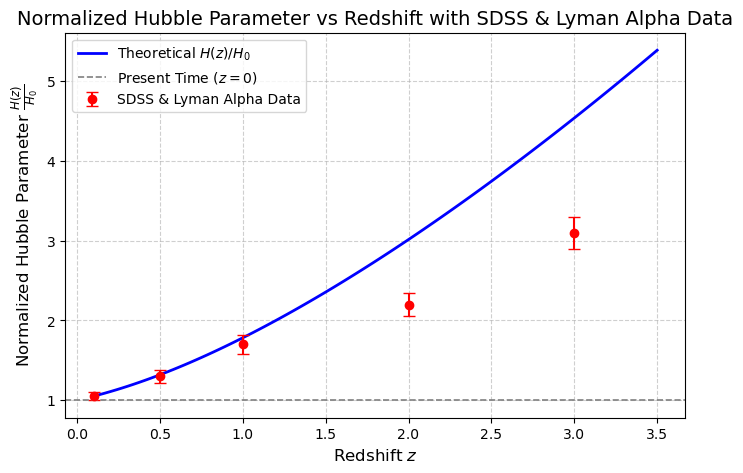

In [9]:
# Generate redshift values and compute H(z)/H0
z = np.linspace(0.1, 3.5, 100)
hubble_values = bg_ref.hubble_normalized_z(z)

# Experimental data: SDSS, Lyman Alpha Forest, etc. [z, H(z)/H0, error]
exp_data = np.array([
    [0.1, 1.05, 0.05],   # Example SDSS-like data
    [0.5, 1.30, 0.08],   # Example SDSS data
    [1.0, 1.70, 0.12],   # Example galaxy survey data
    [2.0, 2.20, 0.15],   # Lyman Alpha Forest data
    [3.0, 3.10, 0.20]    # Lyman Alpha Forest data
])
z_exp = exp_data[:, 0]
h_exp = exp_data[:, 1]
h_err = exp_data[:, 2]

# Plot theoretical curve
plt.figure(figsize=(8, 5))
plt.plot(z, hubble_values, label=r'Theoretical $H(z)/H_0$', color='blue', linewidth=2)

# Plot experimental data with error bars
plt.errorbar(z_exp, h_exp, yerr=h_err, fmt='o', color='red', label='SDSS & Lyman Alpha Data', capsize=4)

# Add horizontal line at H(z)/H0 = 1
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1.2, label='Present Time ($z=0$)')

# Axis labels
plt.xlabel(r'Redshift $z$', fontsize=12)
plt.ylabel(r'Normalized Hubble Parameter $\frac{H(z)}{H_0}$', fontsize=12)

# Title, legend, and grid
plt.title('Normalized Hubble Parameter vs Redshift with SDSS & Lyman Alpha Data', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()

Erros bars and data points are illustrative only, Ensure to you use the correct informations